# Selecting lags on a real world example using correlation based methods

In this notebook we show how we can determine what lags to use for forecasting using three methods: domain knowledge, feature selection & modelling, and correlation based methods.

In this notebook we shall show how we can use **correlation based methodse** to decide which lags we could use.

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The dataset was collected between January 2004 and March 2005.

It consists of hourly measurements of the different air pollutants: NO2, NOX, CO, C6H6, O3 and NMHC. The measurements are accompanied by local temperature and humidity values, also recorded hourly.

In the data collection experiments, scientists were testing new pollutant sensors. The values from the new sensors are stored in the variables called "_sensors". 

For comparison, data for the pollutants was also gathered from fixed stations that regularly measure the concentration of these gases. Those values are stored in the variables called "_true".

## Challenge

This dataset is particularly challenging because it does not have equidistant timestamps. The timestamps should be equidistant because the scientists aimed to have a pollutant record for each hour. But in practice, we have entire days of recordings missing, probably due to data collection failure.

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.seasonal import MSTL, STL, seasonal_decompose
from matplotlib.ticker import MaxNLocator

import seaborn as sns

sns.set_context("paper")

# Functions

In [2]:
def plot_ccf(x, y, lags):
    # Compute CCF and confidence interval
    cross_corrs = ccf(x, y)
    ci = 2 / np.sqrt(len(y))
    # Create plot
    fig, ax = plt.subplots(figsize=[10, 5])
    ax.stem(range(0, lags + 1), cross_corrs[: lags + 1])
    ax.fill_between(range(0, lags + 1), ci, y2=-ci, alpha=0.2)
    ax.set_title("Cross-correlation")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel('lag')
    return ax

In [3]:
def lag_plot(x, y, lag, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=[5, 5])
    ax.scatter(y=y, x=x.shift(periods=lag), s=10)
    ax.set_ylabel("$y_t$")
    ax.set_xlabel(f"$x_{{t-{lag}}}$")
    return ax

# Load data

In [4]:
filename = "../datasets/AirQualityUCI_ready.csv"
data = pd.read_csv(filename, parse_dates=["Date_Time"], index_col=["Date_Time"])

data.sort_index(inplace=True)
data.head()

,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-01-04 00:00:00,1.6,1143.0,106.0,6.3,825.0,96.0,986.0,86.0,1477.0,978.0,12.0,61.6,0.8593
2004-01-04 01:00:00,1.2,1044.0,100.0,5.1,770.0,85.0,1031.0,70.0,1425.0,944.0,11.5,63.9,0.8652
2004-01-04 02:00:00,1.1,1034.0,71.0,4.1,716.0,50.0,1085.0,55.0,1405.0,891.0,10.7,67.2,0.8630
2004-01-04 03:00:00,0.9,956.0,72.0,4.0,713.0,-200.0,1099.0,-200.0,1422.0,849.0,9.0,73.1,0.8394
2004-01-04 04:00:00,0.7,909.0,44.0,2.4,615.0,57.0,1237.0,49.0,1322.0,790.0,10.2,66.6,0.8299


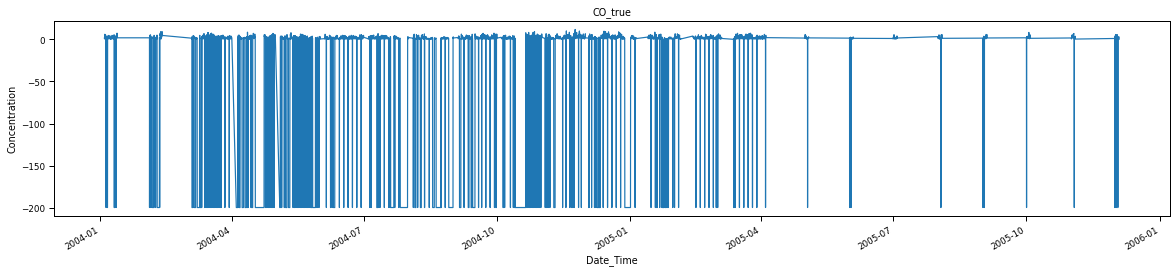

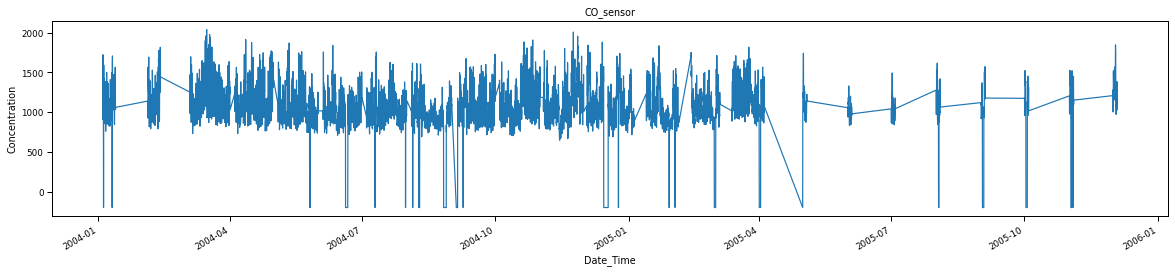

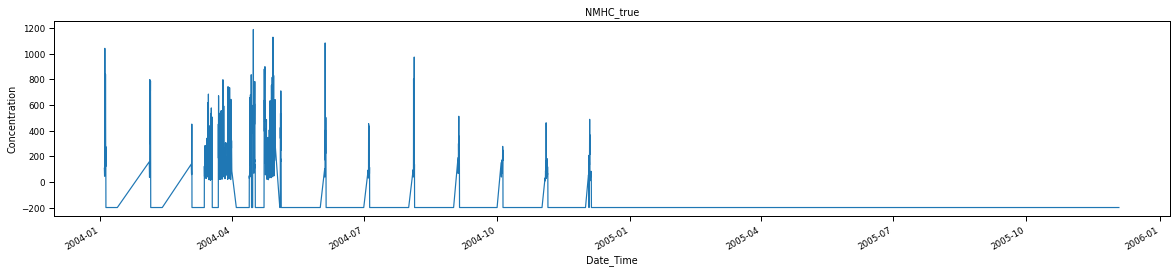

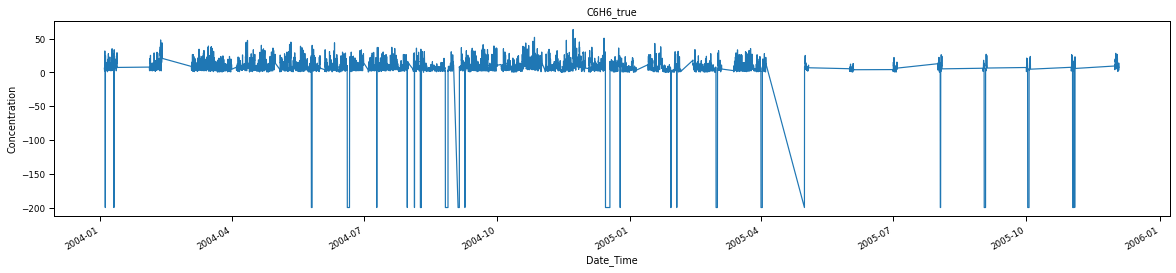

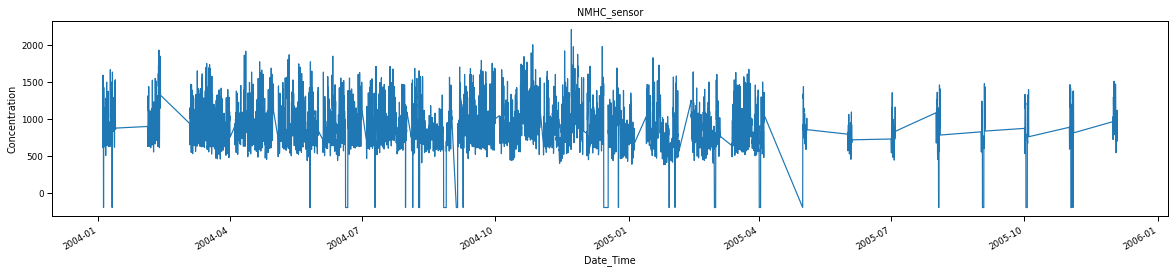

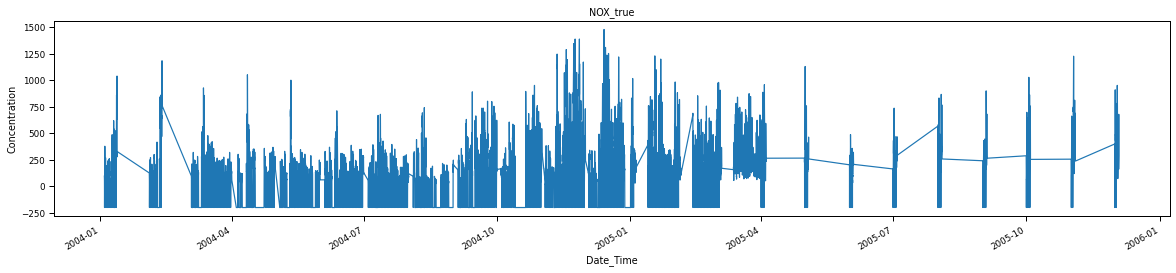

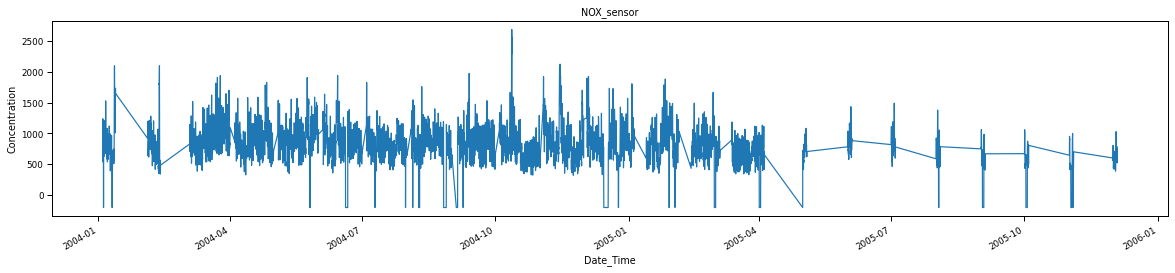

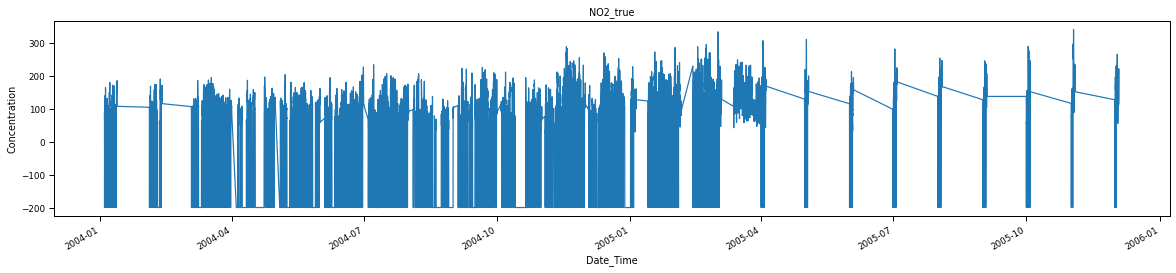

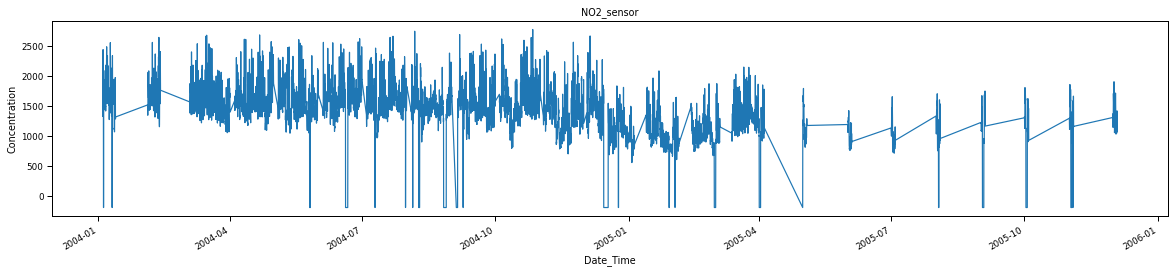

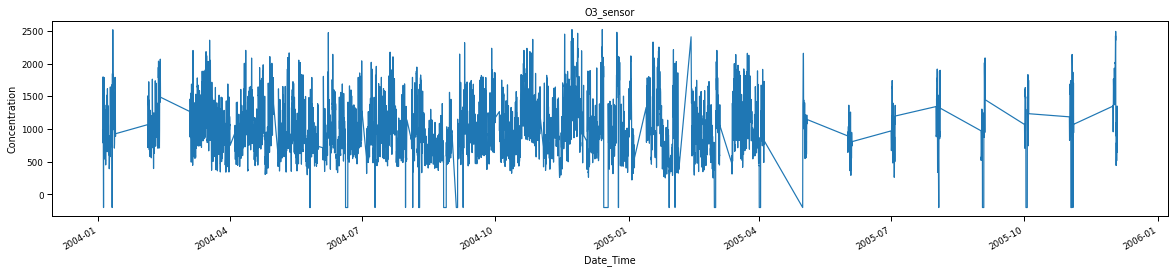

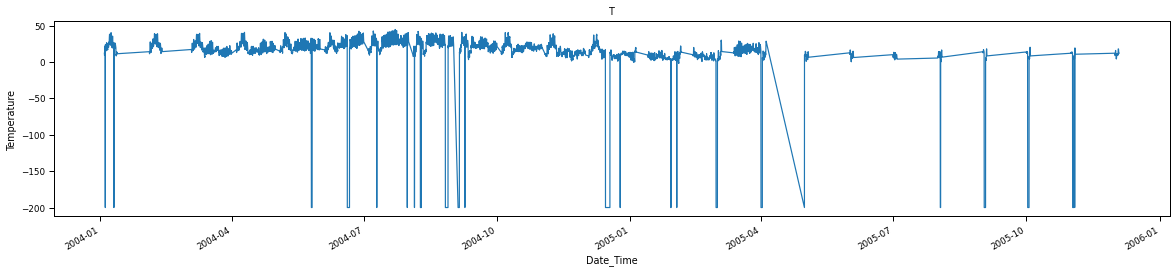

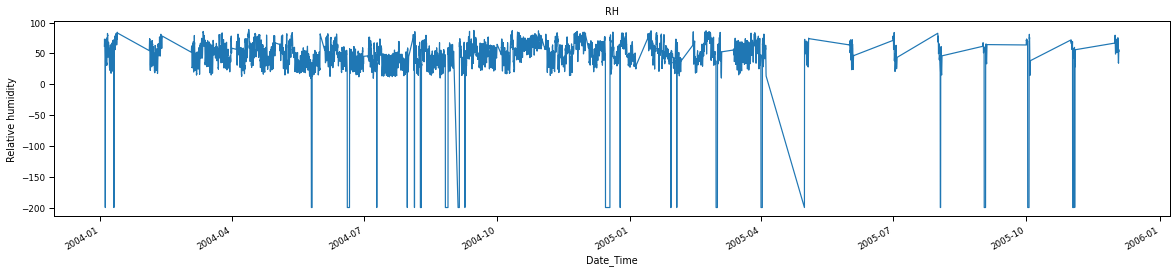

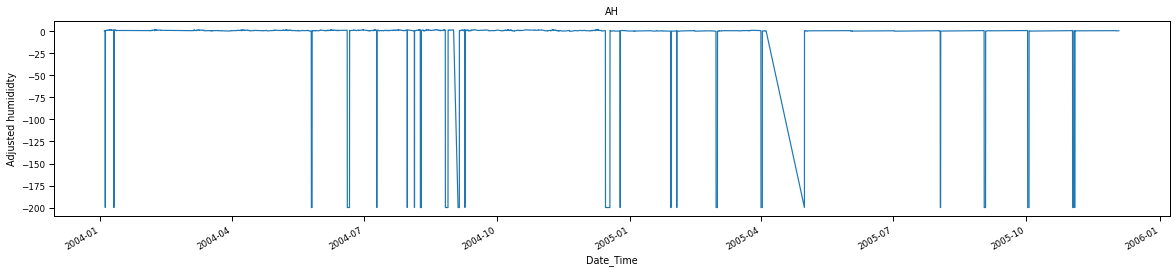

In [5]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.show()

See the analysis in section 2 notebook 2. Due to data quality issues we will for this demo:

- reduce the data to the span between March 2004 and April 2005 (best quality).

- resample the time series to ensure that the time between each row is one hour.

- work only with the sensor values.

- remove negative values, that is, remove outliers.




In [6]:
# Reduce the time span.
data = data["2004-04-01":"2005-04-30"]

In [7]:
# Resample freq to be hourly. If there are gaps larger
# than one hour they will be representing as NaNs.
data = data.asfreq("1H")

In [8]:
# Remove measurements from fixed stations.
# We'll only be using sensor data.
drop_vars = [var for var in data.columns if "_true" in var]

# Remove adjusted humidity.
drop_vars.append("AH")

# Remove variables.
data.drop(labels=drop_vars, axis=1, inplace=True)

In [9]:
# Impute negative values with NaNs
data[data < 0] = np.NaN

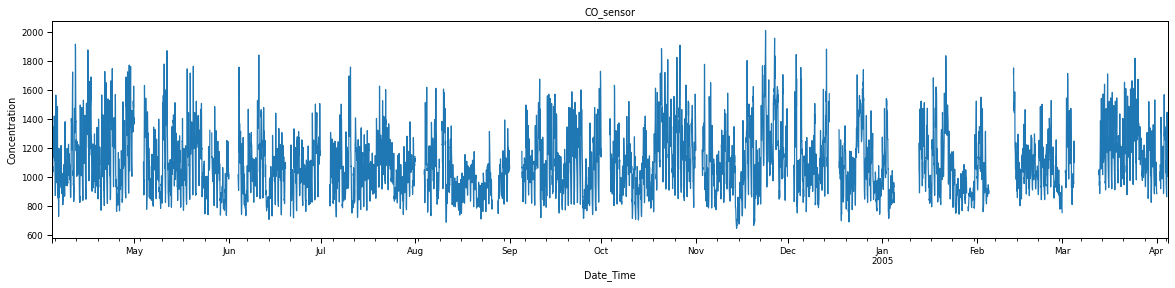

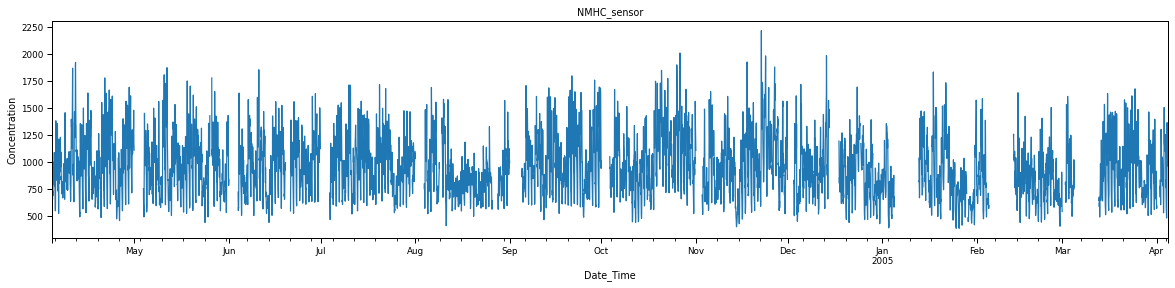

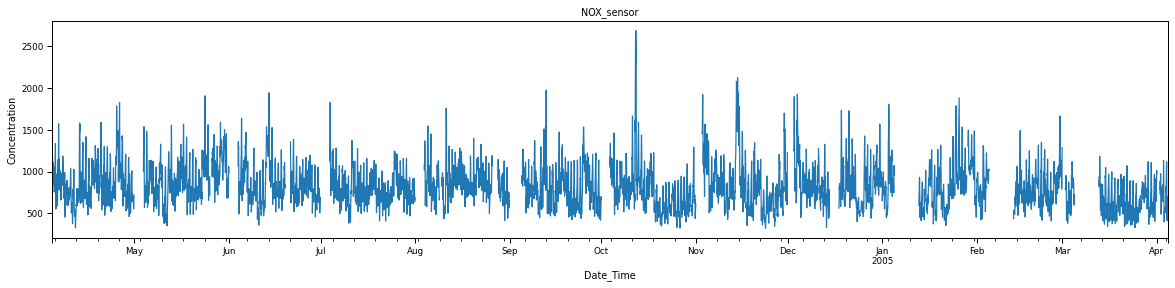

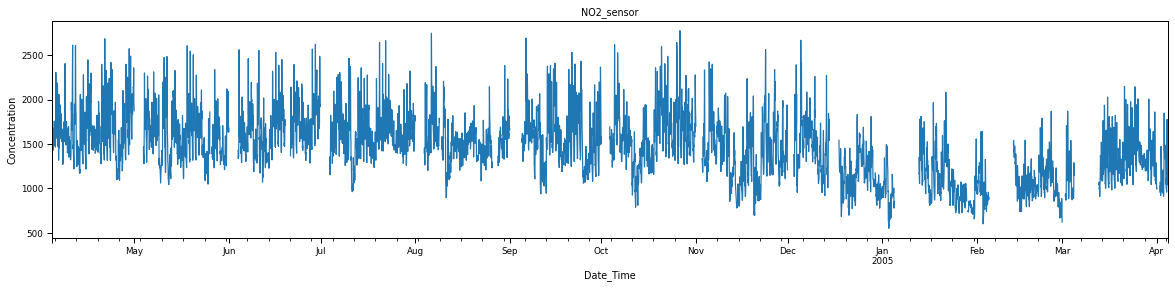

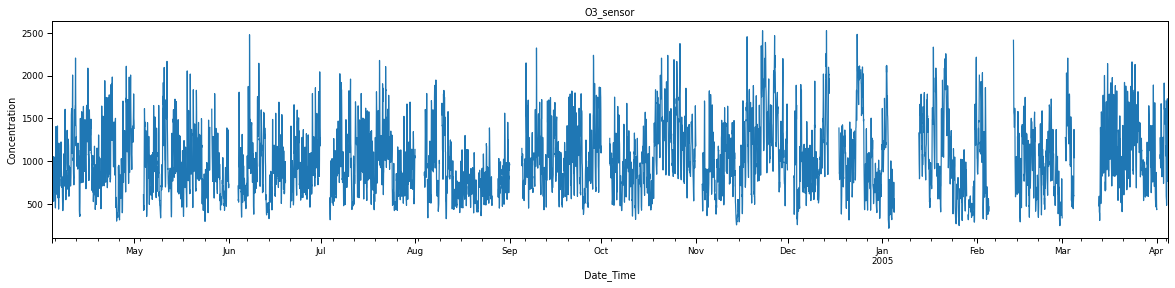

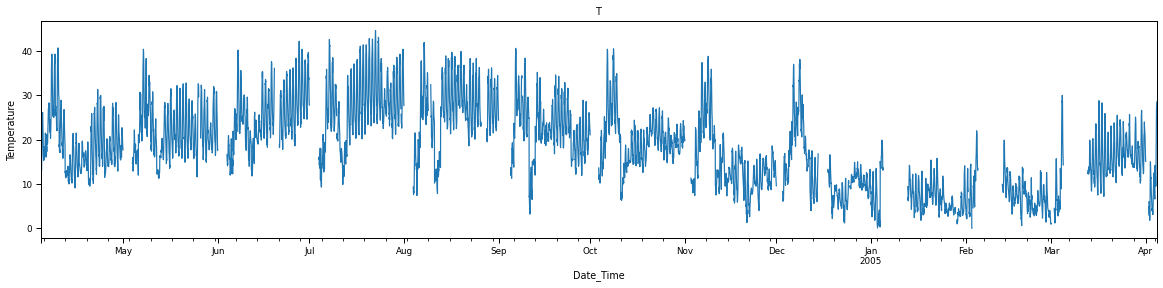

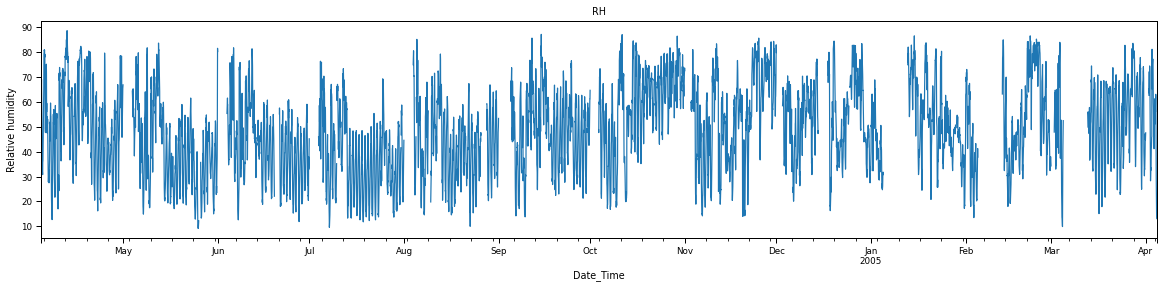

In [10]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.show()

# Using correlation based measures

We will need till the missing data before computing the ACF, PACF, CCF.

In [11]:
data = data.fillna(method='ffill')

In [12]:
# Sanity check
data.isnull().any()

CO_sensor      False
NMHC_sensor    False
NOX_sensor     False
NO2_sensor     False
O3_sensor      False
T              False
RH             False
dtype: bool

## Autocorrelation function (ACF) and partial autocorrelation function (PACF)

Let's plot the ACF and PACF for each variable. Let's start by looking at lags up to 7 days ago. We ought to be cautious when examining the PACF as we know that due to seasonality and trend the data is not stationary.

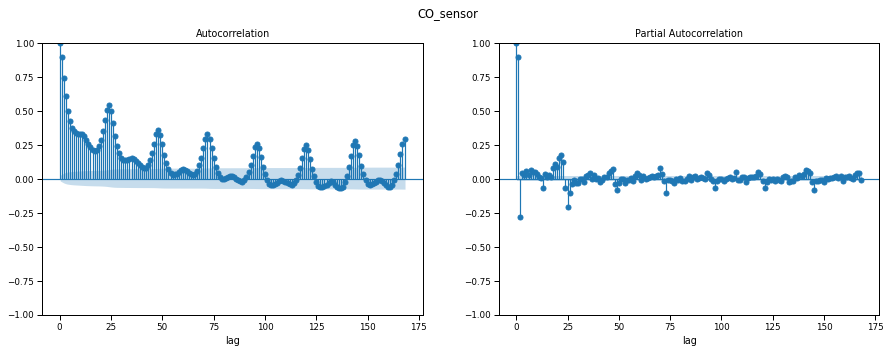

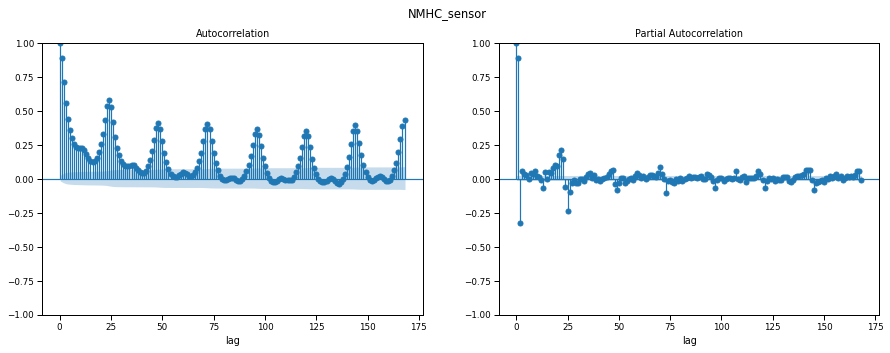

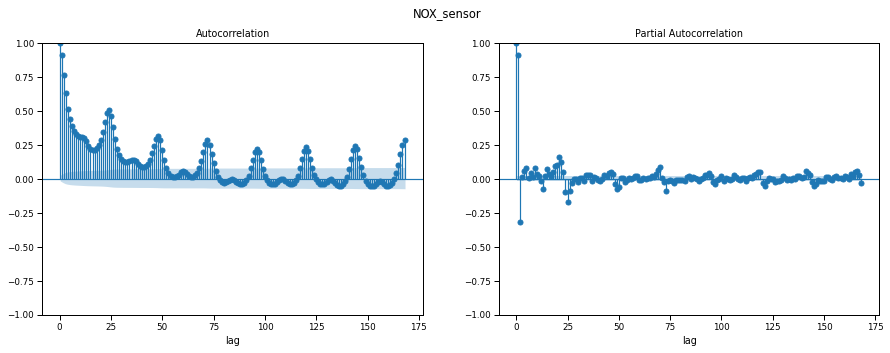

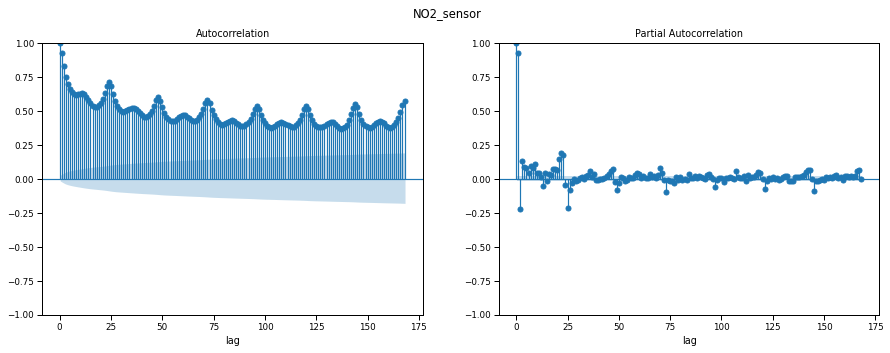

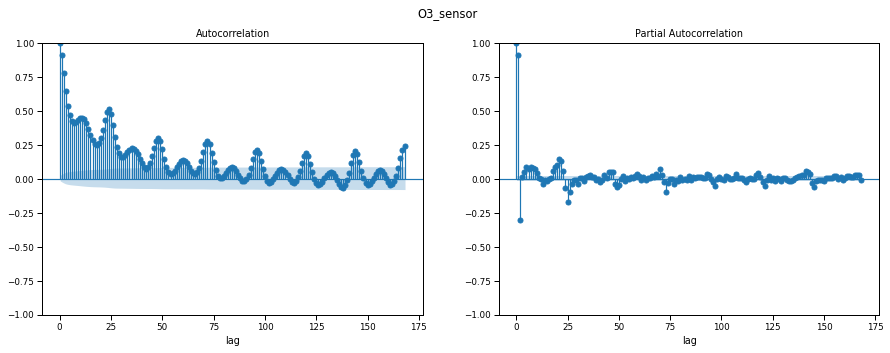

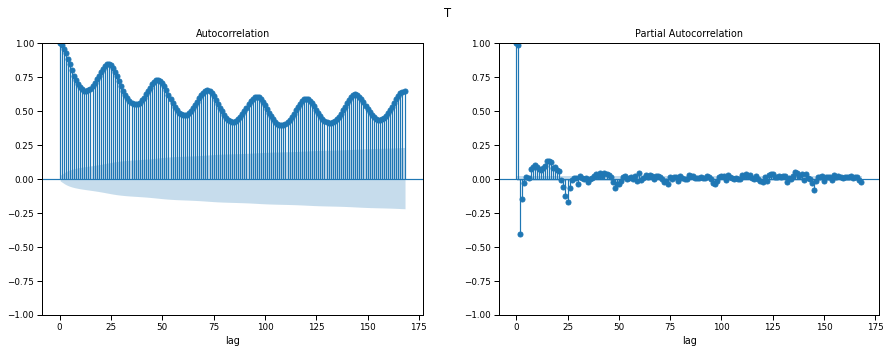

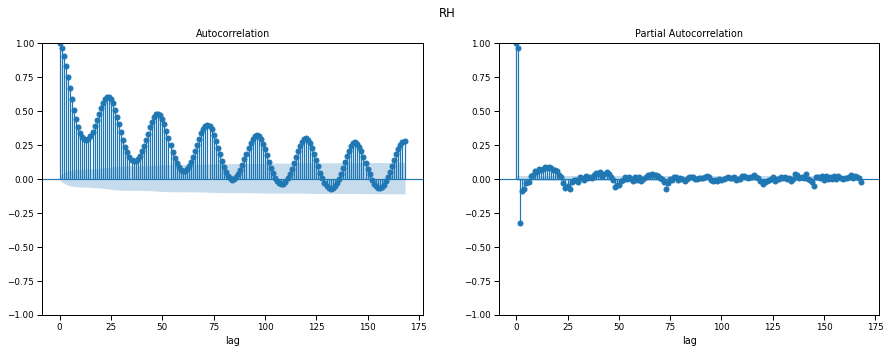

In [13]:
for col in data.columns:
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plot_acf(data[col], lags=7 * 24, ax=ax[0])
    ax[0].set_xlabel('lag')
    plot_pacf(data[col], lags=7 * 24, ax=ax[1], method="ywmle")
    ax[1].set_xlabel('lag')
    fig.suptitle(col)

The ACF shows periodic peaks at multiples of 24 hours. Some sensors also show a peak occuring at multiples of 12 hours. This is corroborated with the PACF showing a peak at 24 hours. Let's zoom in and look at the plots over a smaller set of lags to confirm what we see.

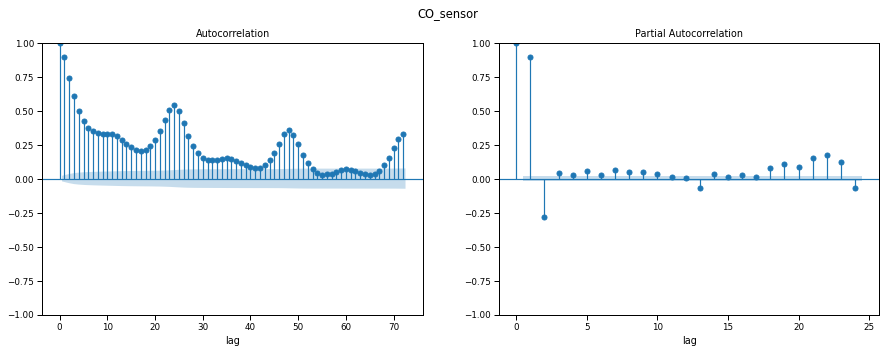

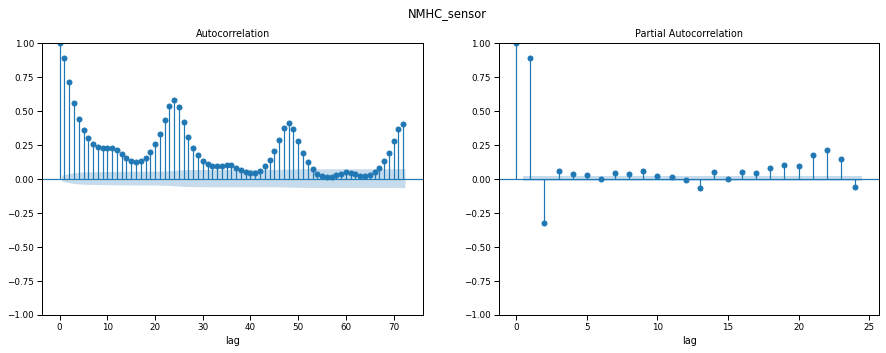

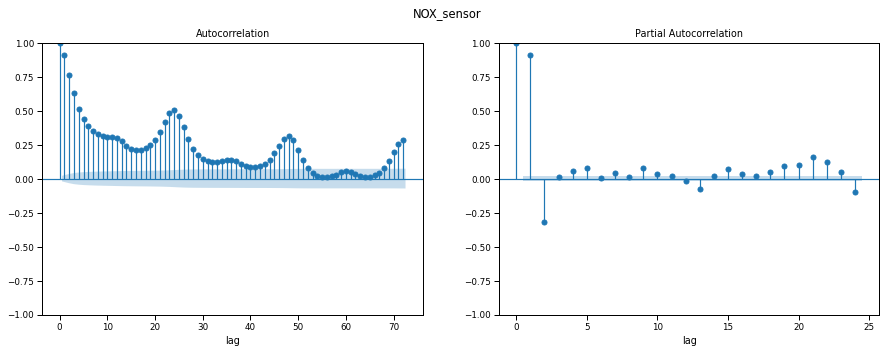

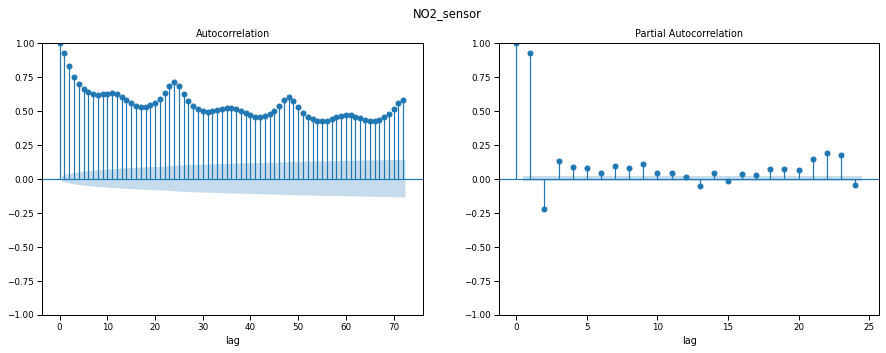

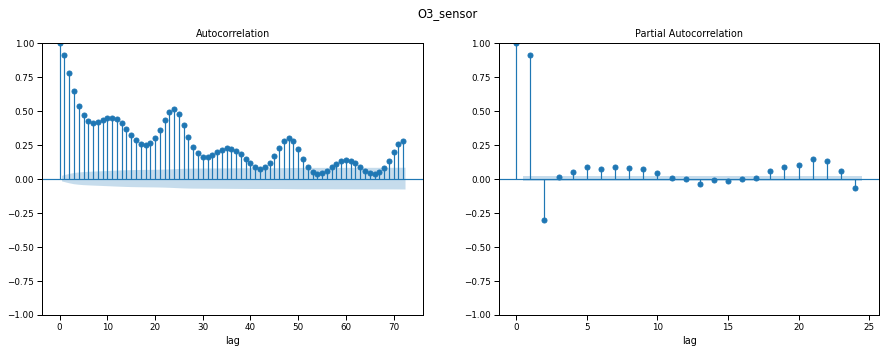

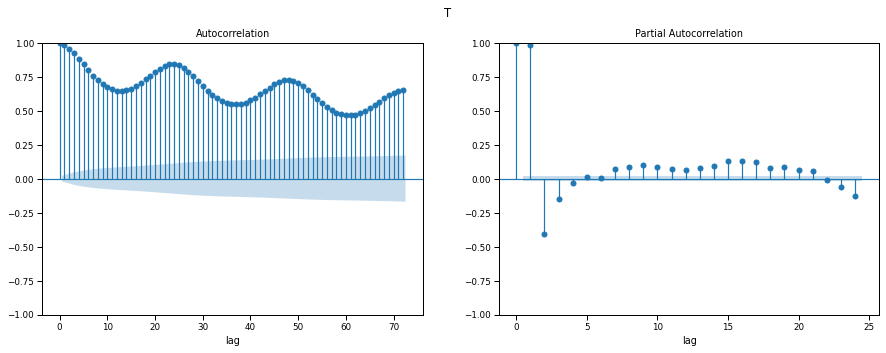

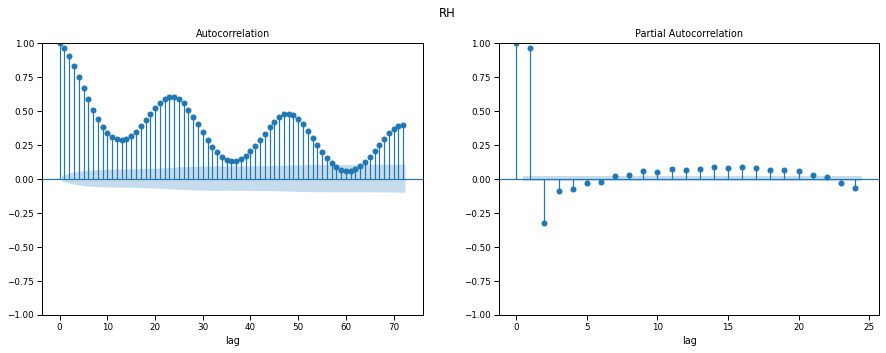

In [14]:
for col in data.columns:
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plot_acf(data[col].dropna(), lags=3 * 24, ax=ax[0])
    ax[0].set_xlabel('lag')
    plot_pacf(data[col].dropna(), lags=1 * 24, ax=ax[1], method="ywmle")
    ax[1].set_xlabel('lag')
    fig.suptitle(col)

The ACF definitely has peaks at 12 hour periods for some sensors. This is confirmed in the PACF where we see a little peak close to a lag of 12 or 13. The PACF shows that typically it is the most recent lags (e.g., 1 or 2 hours) that matter the most and that there is some seasonality potentially with periods 12 and 24. This confirms what we have so far seen in this dataset using domain knowledge and feature selection methods.

Let's look at the ACF at just over 2 weeks worth of lags to see if there is any weekly seasonality visible. We'll also look at the PACF and see if there are any peaks close to 1 week.

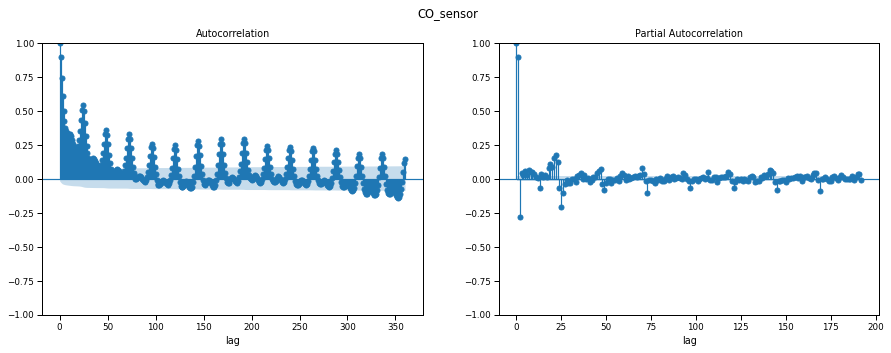

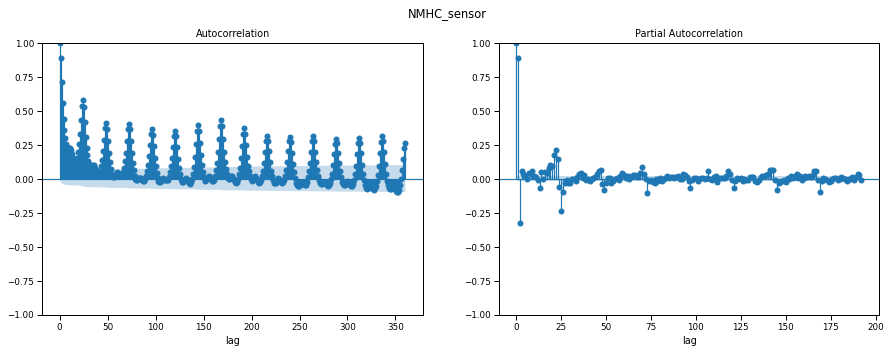

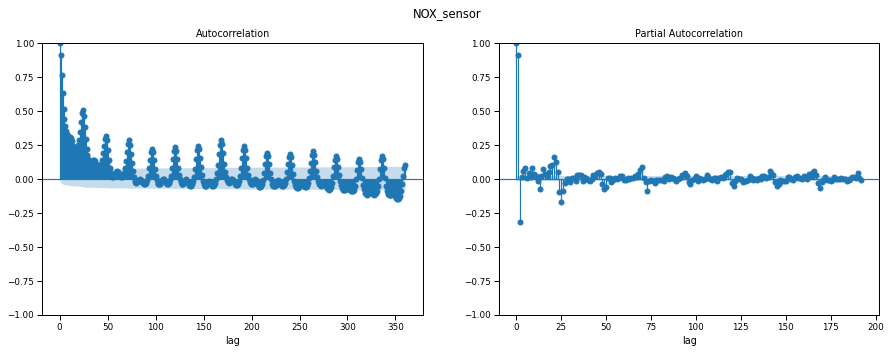

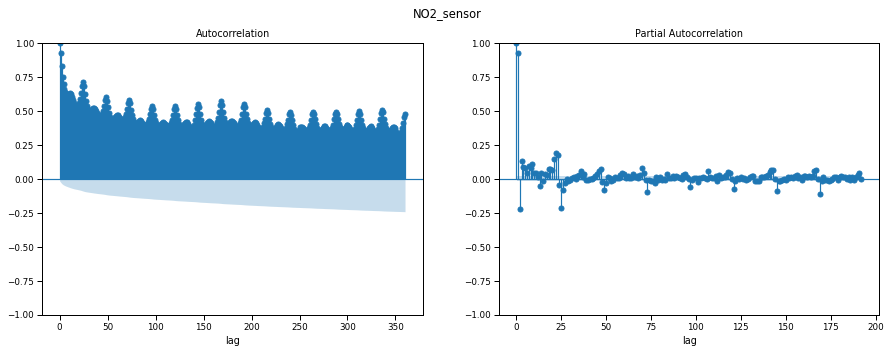

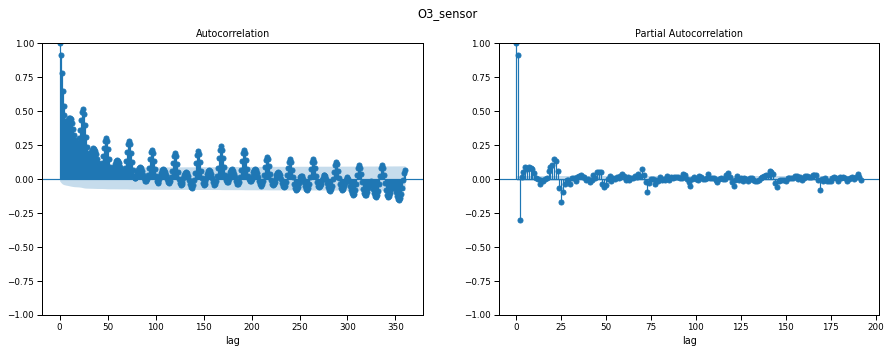

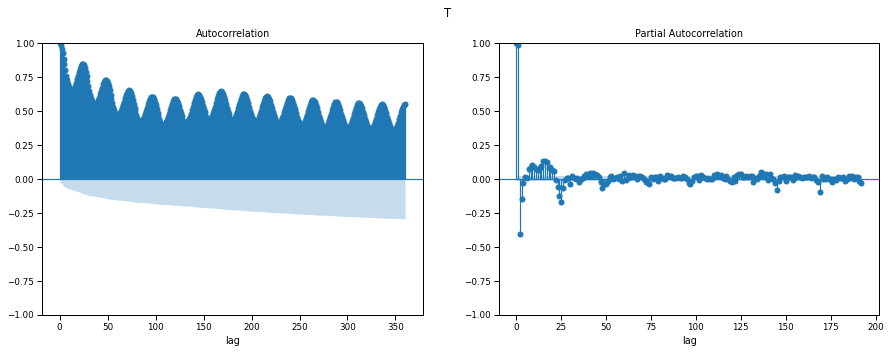

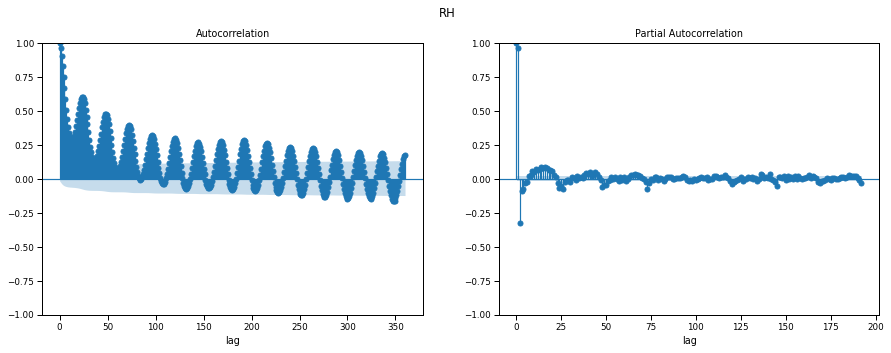

In [15]:
for col in data.columns:
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plot_acf(data[col].dropna(), lags=15 * 24, ax=ax[0])
    ax[0].set_xlabel('lag')
    plot_pacf(data[col].dropna(), lags=8 * 24, ax=ax[1], method="ywmle")
    ax[1].set_xlabel('lag')
    fig.suptitle(col)

The ACF suggests there could be another peak occuring at 168 hours (i.e., 1 week). This is hinted at in the PACF but isn't always clear.

So far from looking at the ACF and PACF we would use recent lags (1 or 2 hours) and seasonal lags (12, 24, and 168 hours). This agrees with everything seen so far in the previous two notebooks using domain knowledge and a feature selection method.

The PACF assumes that the time series are stationary. We can try making them stationary by removing any trend and the multiple seasonal components using time series decomposition methods. When we compute the CFF we will also want to remove the common seasonality all these time series have to find useful lags beyond the seasonal ones. Also we don't want to use another time series as a feature just because it has the same seasonality as the one we want to predict.

## De-trend and de-seasonalise the data

As the time series has multiple seasonal components we shall use MSTL to decompose the time series into trend and multiple seasonal components. The residual is equivalent to subtracting the original series by the trend and seasonal components. So we shall look at the ACF and PACF of the residuals of the decomposition.

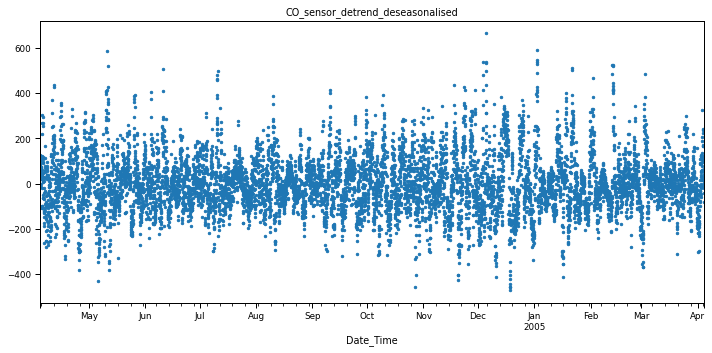

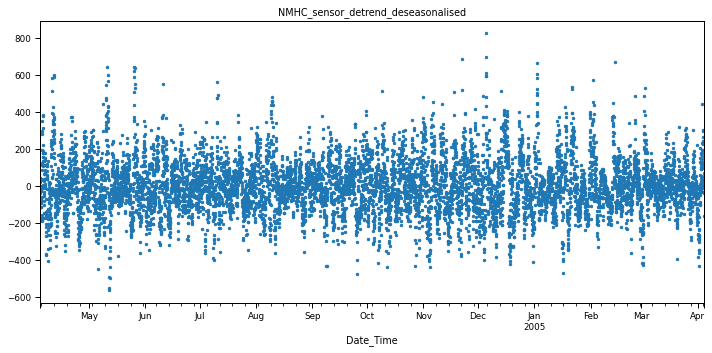

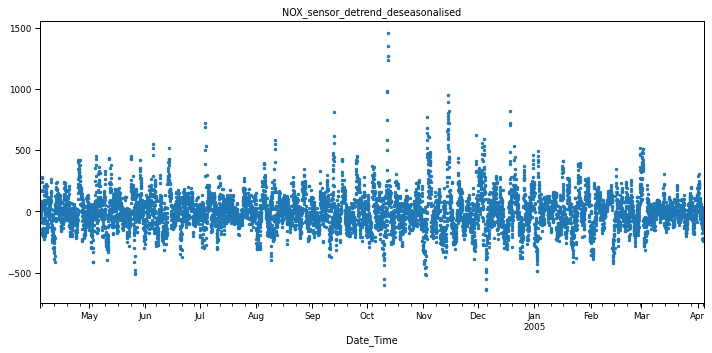

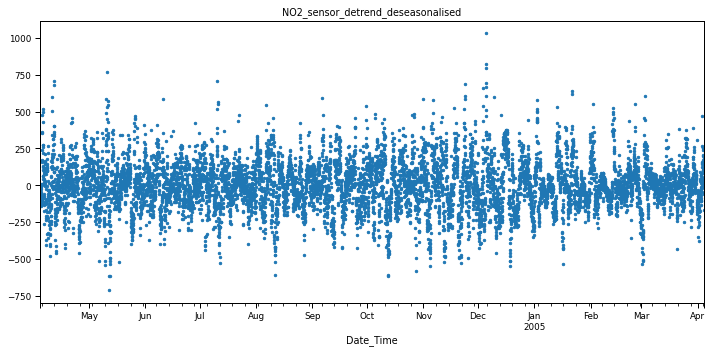

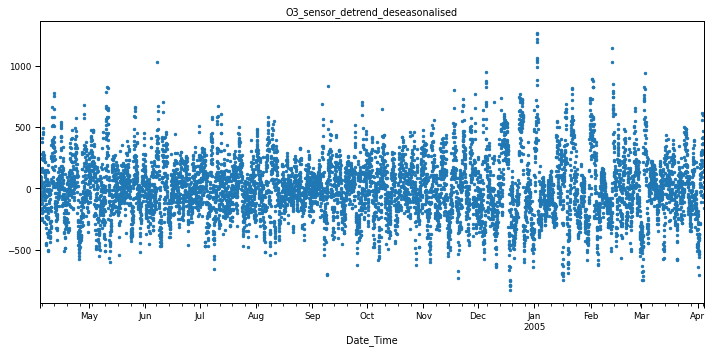

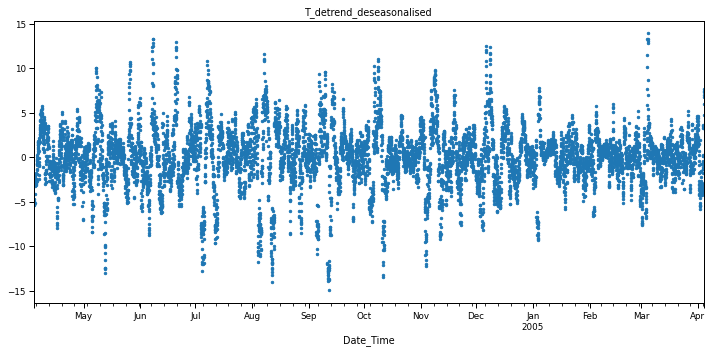

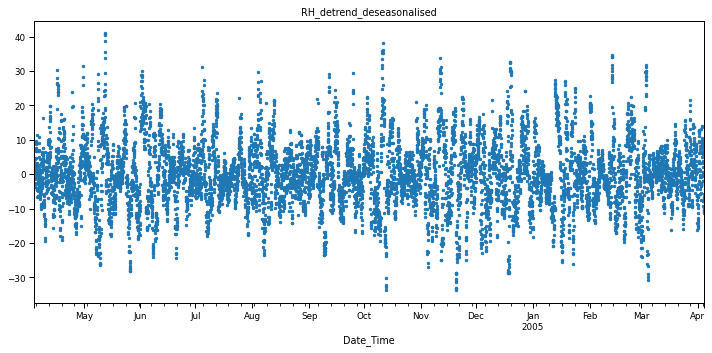

In [16]:
for col in data.columns:
    res = MSTL(
        endog=data[col],
        periods=[24, 24 * 7], # daily and weekly seasonality
    ).fit()
    fig, ax = plt.subplots(ncols=1, figsize=[10, 5])
    res.resid.plot(ax=ax, marker='.', linestyle='None')
    col_name = col + '_detrend_deseasonalised'
    ax.set_title(col_name)
    data[col_name] = res.resid
    plt.tight_layout()

We see that there is less structure in the residuals (i.e., after substracting trend and seasonality). But it doesn't look like white noise. So there might still be some structure. Let's look at the ACF and PACF of this.

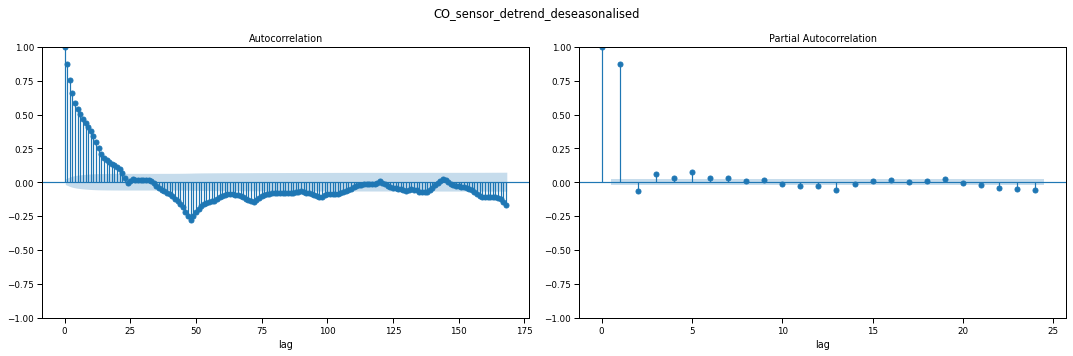

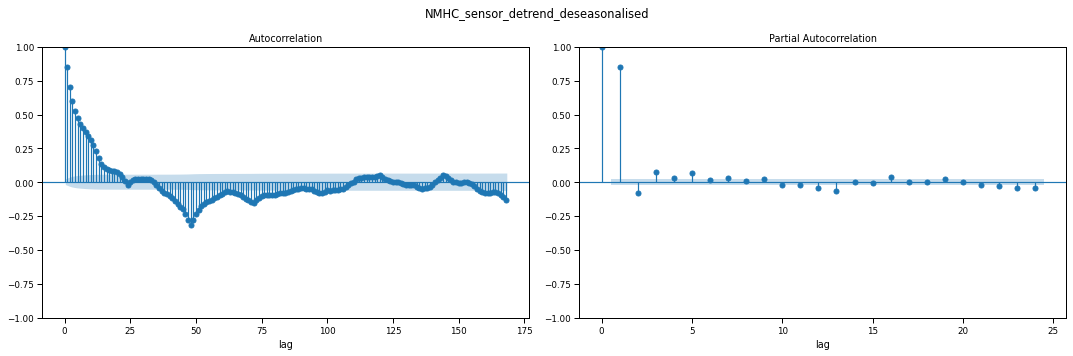

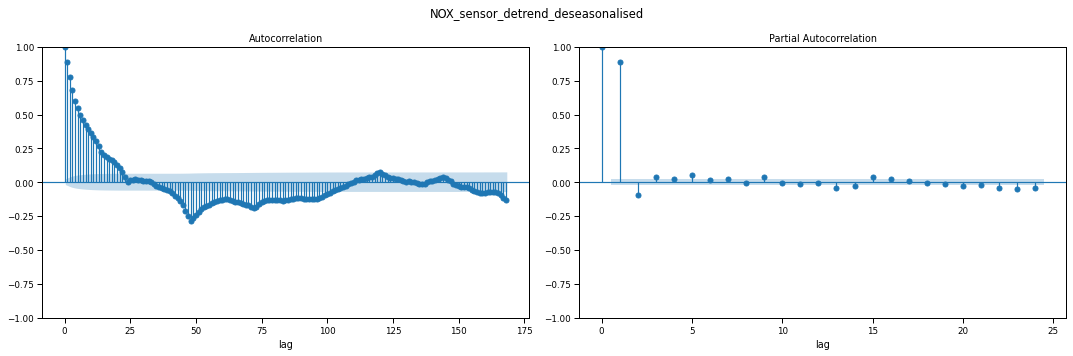

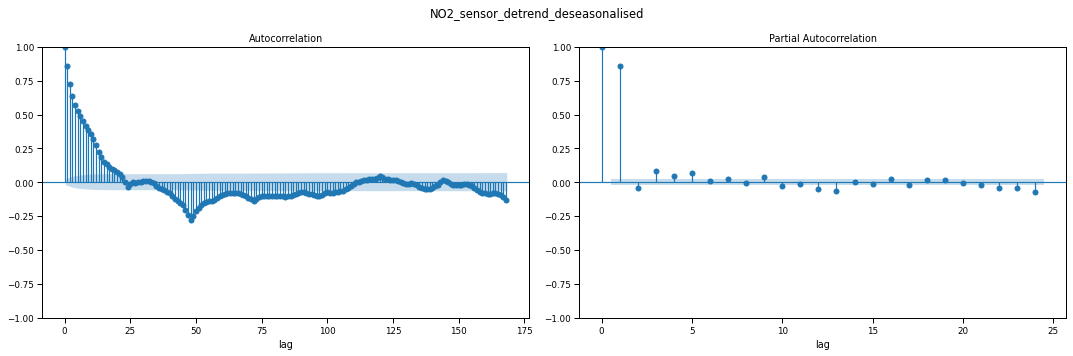

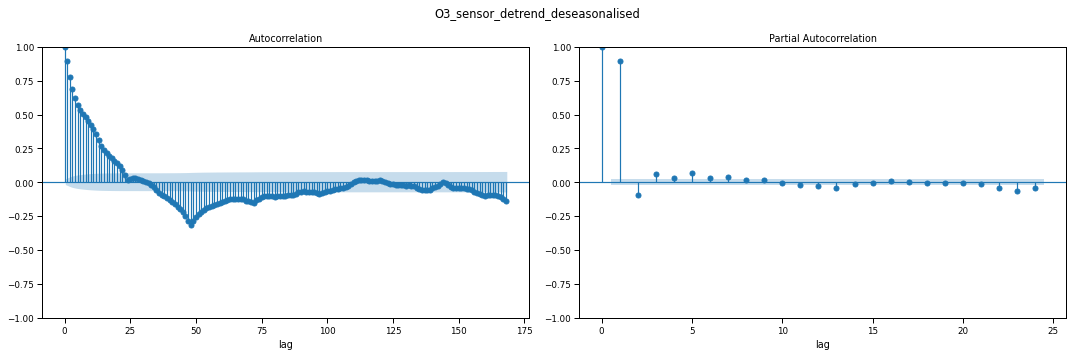

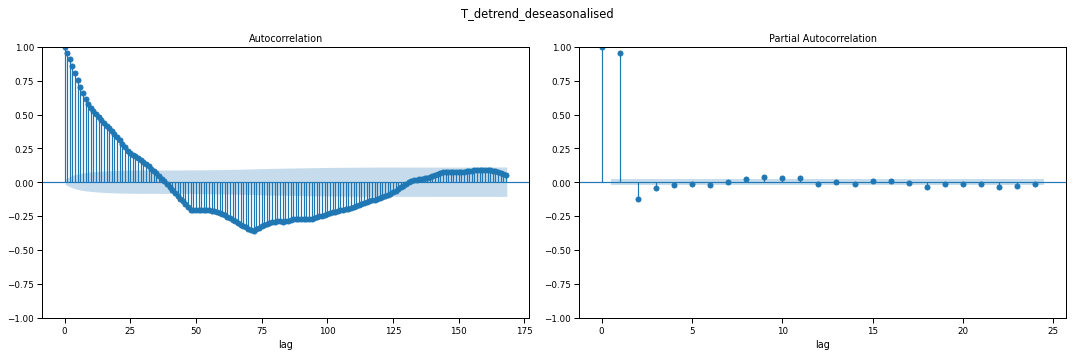

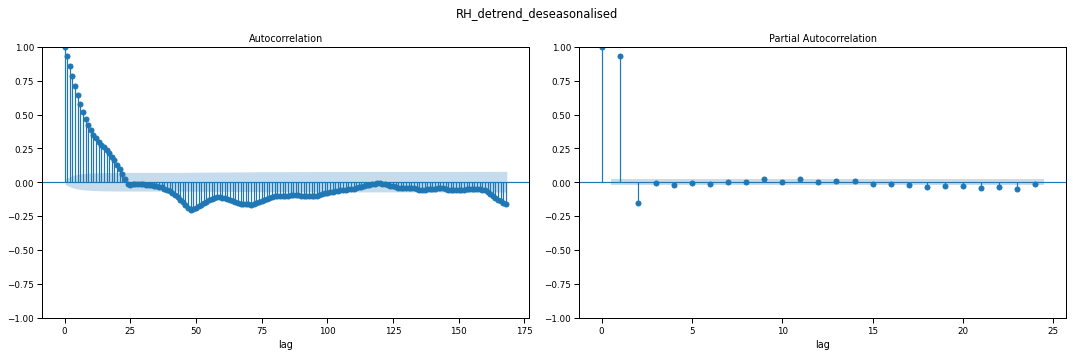

In [17]:
for col in [col for col in data.columns if 'detrend' in col]:
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plot_acf(data[col].dropna(), lags=7 * 24, ax=ax[0])
    ax[0].set_xlabel('lag')
    plot_pacf(data[col].dropna(), lags=1 * 24, ax=ax[1], method="ywmle")
    ax[1].set_xlabel('lag')
    fig.suptitle(col)
    plt.tight_layout()

The ACF decays more quickly now which means that data is closer to being stationary (the ACF decaying quickly is one indicator of a stationary time series). The PACF suggests that a lag of 1 and with less confidence 2 hours could be useful. 

## Cross-correlation function (CCF)

Let's see if there is any cross-correlation between any of the variables and `NO2_sensor`.

Let's see what happens if we don't remove seasonality and trend.

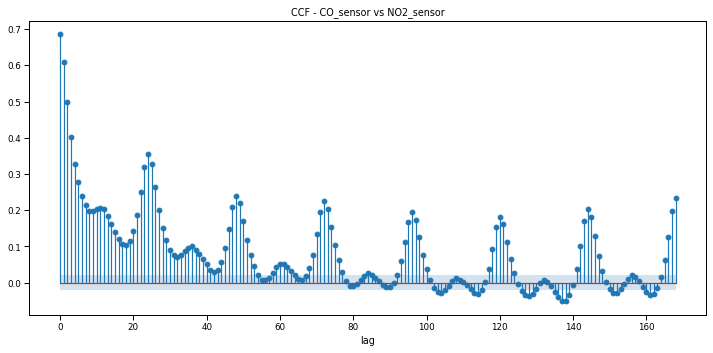

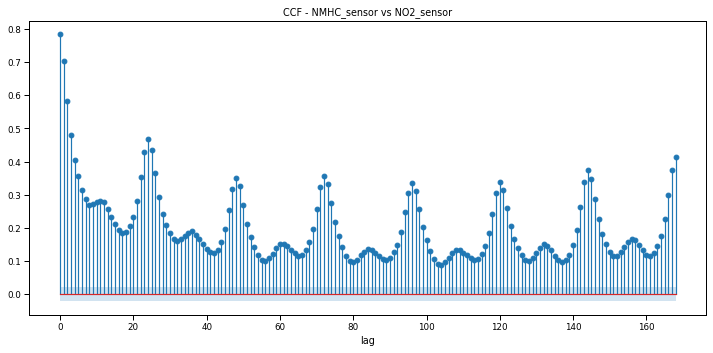

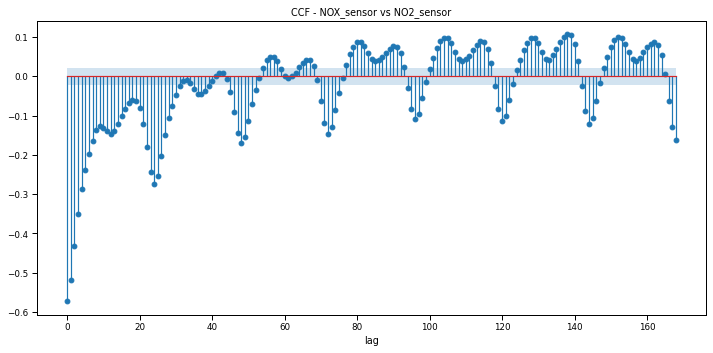

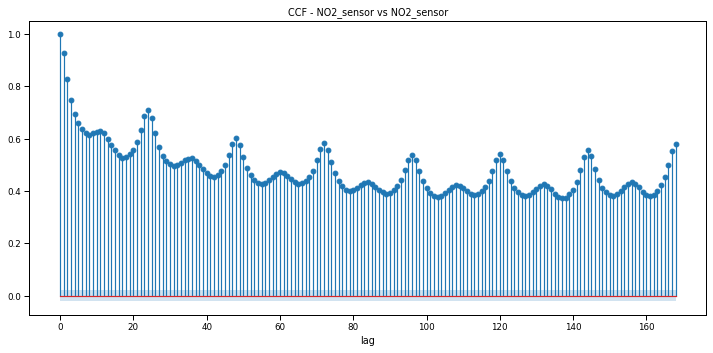

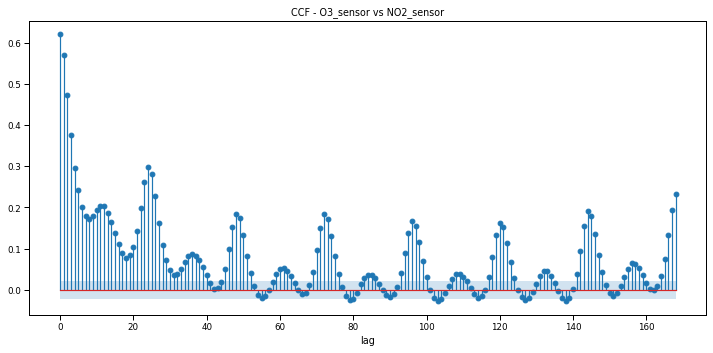

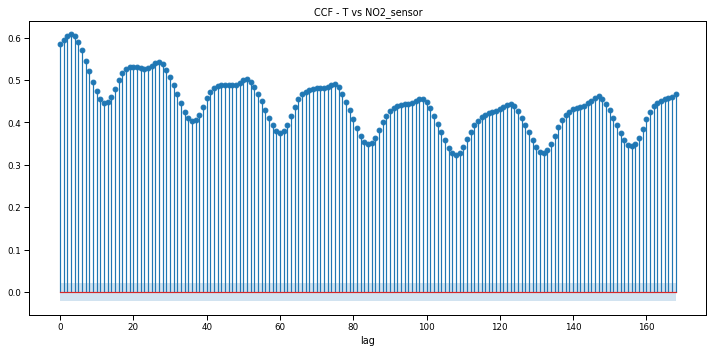

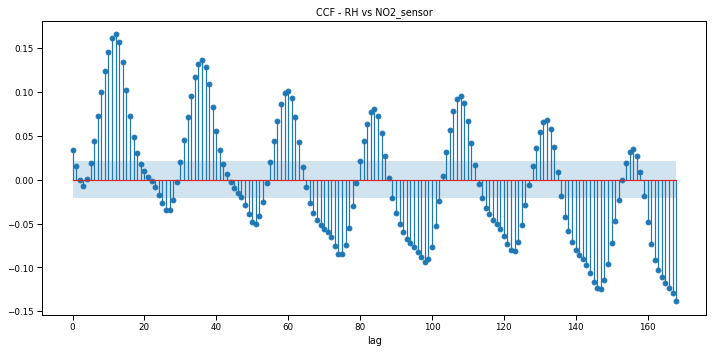

In [18]:
for col in['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor',
       'T', 'RH']:
    ax = plot_ccf(y=data.dropna()['NO2_sensor'], x=data.dropna()[col], lags=24*7)
    ax.set_title(f"CCF - {col} vs NO2_sensor")
    plt.tight_layout()

We see that the CCF shows periodicity of 24 hours because all the time series have some daily seasonality. This illustrates further why this is not a particularly helpful view and that we should de-trend and de-seasonalise the data.

Let's compare it with after we have removed trend and seasonality.

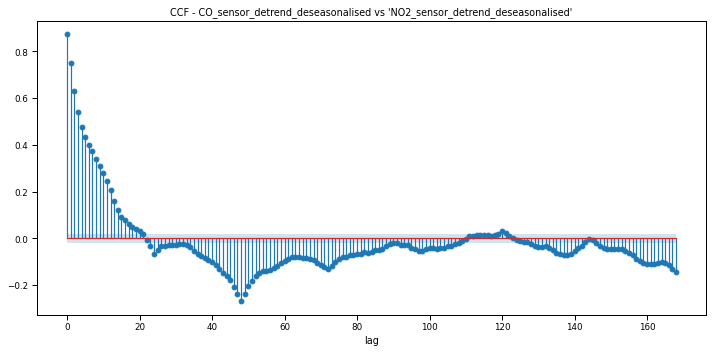

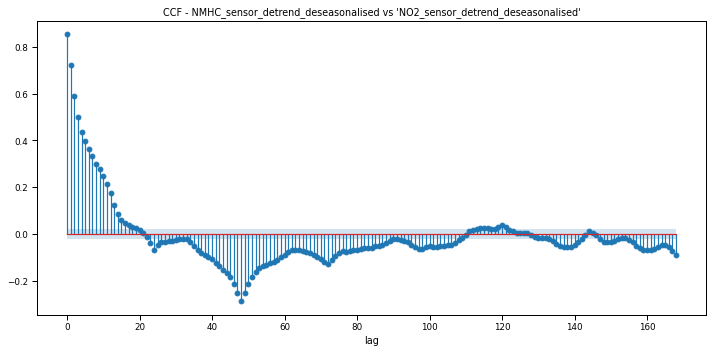

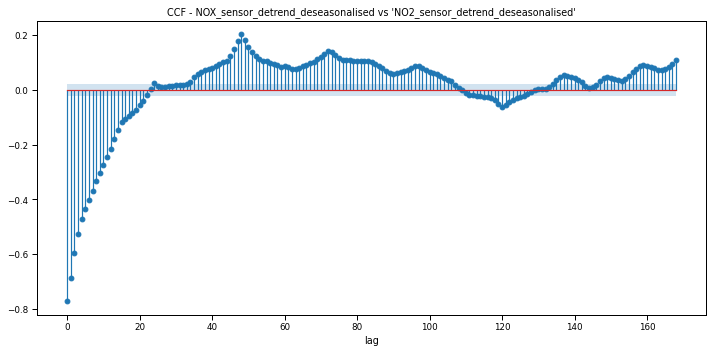

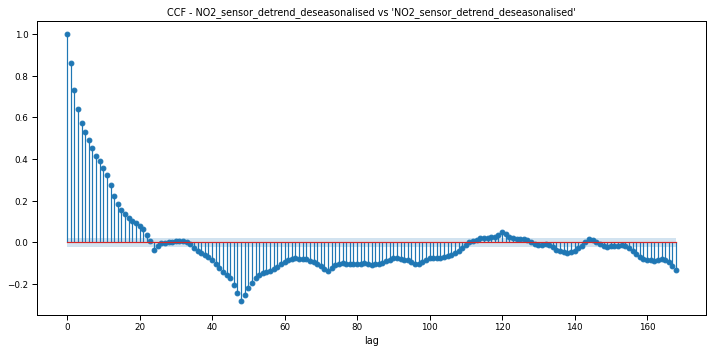

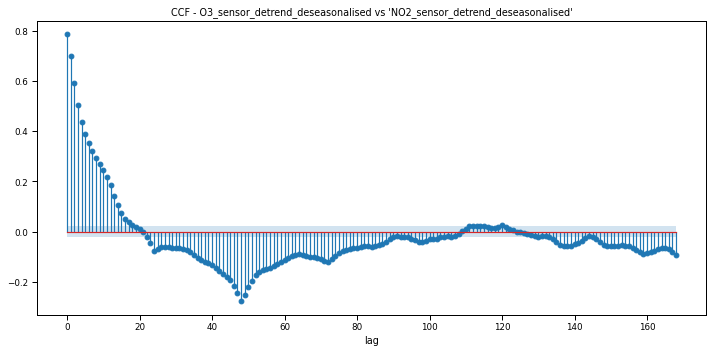

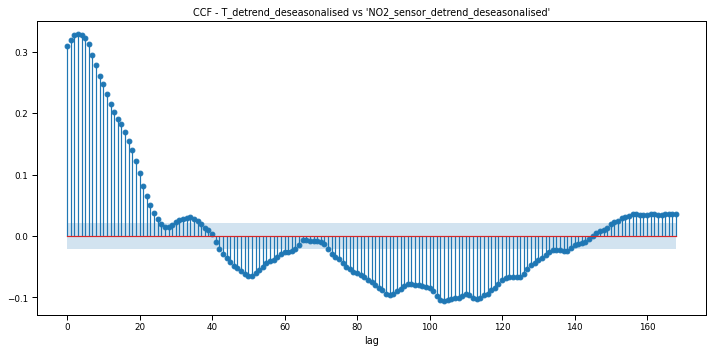

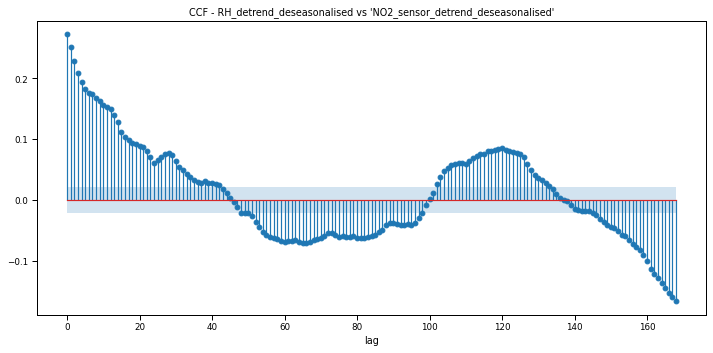

In [19]:
for col in [col for col in data.columns if 'detrend' in col]:
    ax = plot_ccf(y=data.dropna()['NO2_sensor_detrend_deseasonalised'], x=data.dropna()[col], lags=24*7)
    ax.set_title(f"CCF - {col} vs 'NO2_sensor_detrend_deseasonalised'")
    plt.tight_layout()

Even after de-trending and de-seasonalising we see that it is difficult to infer useful lags from the CCF. The large values we see for the CCF with respect to temperature and relative humidity are not particularly helpful and suggest there may still be some trend and seasonality left in the residuals. We see some re-occuring peaks at 24 hour intervals still. This suggests we could include a lag of 24 hours of other features.

However, rather than inferring any strong causality between `NO2_sensor` and any of the other features I am more inclined to conclude that any cross-correlation at 24 hour intervals is driven by the confounding factor of daily seasonality (i.e., traffic and commuting patterns, daylight, temperature, humiditiy). So any uplift from these features would be due to these correlations and hence I anticipate most feature selection methods (e.g., LASSO) would discard these particular lags in favour of lag 24 of the target itself.